## Diagnose inflow angle of K01 and K25 by comparing with Ku-band scatterometers

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Paths & Params
PTHS = {
    'dsg_pth':     '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir':     '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sct_dir':     '/home/arthur/data/tropical_cyclones/scatterometer/hy-2/',
    'K01_PRM_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_LP_KPP_K01/cases/',
    'K01_FIT_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/cases/',
    'K25_PRM_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_LP_KPP_K25_C1C2FIT/cases/',
    'K25_FIT_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/cases/',
}

PRMS = {
    'dt': 90, # Delta time used for collocation, in min
}

### Open data
# SAR
dsg = xr.open_dataset(PTHS['dsg_pth'])

In [3]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20) &

    (dsg.dist2coast  > dsg.r34)             & # Distance to coast
    (dsg.percent_outside < 10)                & # Sufficient SAR coverage
    # (dkg01.vmx > 20)                            & # Test
    # (dkg01.C_K01 != 0.0001)                     & # Reached the lower bound
    # (dkg01.C_K01 != 0.1)                        & # Reached the upper bound
    # (dkg01.asym_avg_err  <= 2.5)                & # Test
    # (dkg01.phase_avg_err <= 45)                 & # Test
    # (~xr.where(dkg01.non_C1 == 0, False, True)) & # Ensure that I > V/r
    ((dsg.storm_speed_ibt / dsg.vws_pmd) > 1) # Ratio storm_speed / wind_shead
)
dsg_filtered    = dsg.where(cond, drop=True)
print(len(dsg_filtered.time))

117


### 1) Collocate SAR and HY-2

In [4]:
# For debug, use t = 90

# Initialize
list_of_collocated_sct_pths = []
list_of_collocated_sar_fles = []

# Iterate
for t in tqdm(range(len(dsg_filtered.time))):
    ### Open SAR
    ds         = dsg_filtered.isel(time=t)

    ### Collocate eventual SCAT data
    # Extract SCAT data from that previous, current, and next day
    year = ds.time.data.astype('datetime64[Y]').astype(int) + 1970 # Year of the current ibt_time
    days = int((ds.time - np.datetime64('{}-01-01'.format(year))) / np.timedelta64(1, 'D')) + 1 # Nb of days since beginning of that year
    # Take previous, current and next day (note that this doesn't cover the beginning or end of a year, in the unlikely occurrence)
    sct_data_crt = np.array(
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days - 1)) +  
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days))     + 
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days + 1))
    )
    # Paths that have the correct ATCF ID
    matching_paths = []
    for path in sct_data_crt:
        filename = os.path.basename(path) 
        if filename.endswith(f"{ds.id.item()}.nc"):
            matching_paths.append(path)
    # Collocated paths
    for matching_path in matching_paths:
        # Open
        ds_matching = xr.open_dataset(matching_path)
        # If collocated, append
        if abs(ds.time - ds_matching.time) < np.timedelta64(PRMS['dt'], 'm'):
            list_of_collocated_sct_pths.append(matching_path)
            list_of_collocated_sar_fles.append(ds.file_tcva.item())
        # Close
        ds_matching.close()
    # Close
    ds.close()
    ### Open models
    # dsp        = xr.open_dataset(PTHS['sar_dir'] + ds.file_tcva.item()).isel(time=0)
    # dsk_prm    = xr.open_dataset(PTHS['K01_PRM_dir'] + ds.file_tcva.item()[:-17] + '.nc').sel(z=10, theta=slice(0, 359))
    # dsk_fit    = xr.open_dataset(PTHS['K01_FIT_dir'] + ds.file_tcva.item()[:-17] + '.nc').sel(z=10).interp(theta=np.array(dsp.theta))

print(len(list_of_collocated_sct_pths))

  0%|          | 0/117 [00:00<?, ?it/s]

13


In [5]:
# Check for duplicates
has_duplicates = len(list_of_collocated_sar_fles) != len(set(list_of_collocated_sar_fles))
if has_duplicates:
    print("La liste contient des doublons.")
else:
    print("La liste ne contient pas de doublons.")

La liste ne contient pas de doublons.


### 2) Compare average inflow angles

#### r-grid

In [6]:
### Open data
# SCAT
dsc_sct = xr.open_mfdataset(list_of_collocated_sct_pths, combine='nested', concat_dim='idx')
# K01 PRM
dsk01p  = xr.open_mfdataset([PTHS['K01_PRM_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')
# K01 FIT
dsk01f  = xr.open_mfdataset([PTHS['K01_FIT_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')
# K25 PRM
dsk25p  = xr.open_mfdataset([PTHS['K25_PRM_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')
# K25 FIT
dsk25f  = xr.open_mfdataset([PTHS['K25_FIT_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')

In [7]:
### Compute inflow angle differences
iadk01p = dsc_sct.inflow_angle.mean(dim='theta', skipna=True) - dsk01p.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 
iadk01f = dsc_sct.inflow_angle.mean(dim='theta', skipna=True) - dsk01f.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 
iadk25p = dsc_sct.inflow_angle.mean(dim='theta', skipna=True) - dsk25p.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 
iadk25f = dsc_sct.inflow_angle.mean(dim='theta', skipna=True) - dsk25f.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 

(0.0, 250000.0)

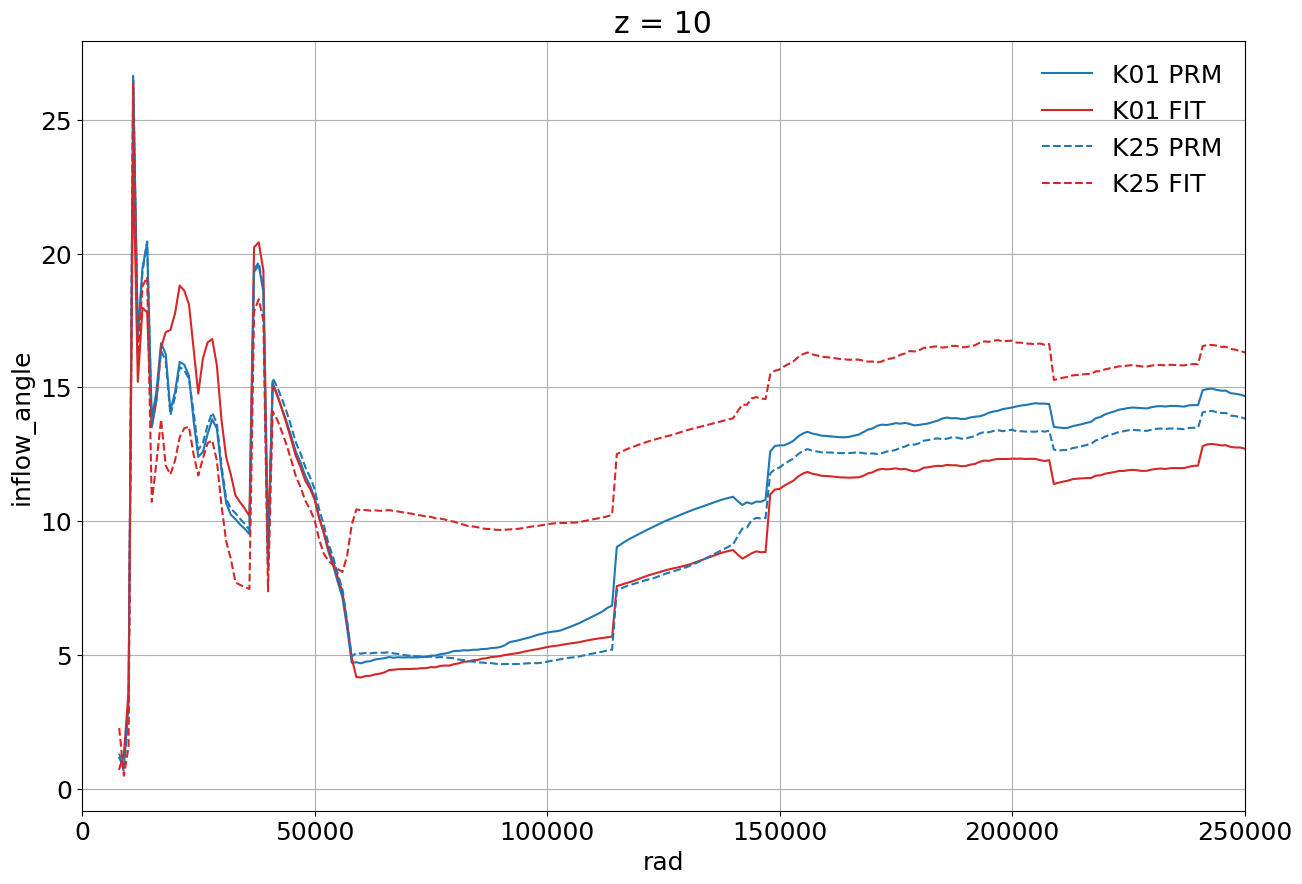

In [8]:
# Plot
abs(iadk01p).mean(dim='idx', skipna=True).plot(label='K01 PRM', c='tab:blue')
abs(iadk01f).mean(dim='idx', skipna=True).plot(label='K01 FIT', c='tab:red')
abs(iadk25p).mean(dim='idx', skipna=True).plot(label='K25 PRM', c='tab:blue', linestyle='dashed')
abs(iadk25f).mean(dim='idx', skipna=True).plot(label='K25 FIT', c='tab:red',  linestyle='dashed')
plt.grid()
plt.legend(frameon=False)
plt.xlim(0, 250000)

#### r*-grid

In [9]:
# r_star
r_star = np.linspace(0, 16, 16 * 8 + 1)

In [10]:
# dsg_filtered.where(dsg_filtered.file_tcva.isin(list_of_collocated_sar_fles), drop=True)

# # Collocated SAR winds
# dsc_sar = xr.open_mfdataset([PTHS['sar_dir'] + path for path in list_of_collocated_sar_fles])

In [11]:
# 1st loop to determine all the rmax values
RMXS = []
for idx, file_tcva in tqdm(enumerate(list_of_collocated_sar_fles)):
    ### Open SAR
    ds         = dsg_filtered.where(dsg_filtered.file_tcva == file_tcva, drop=True)
    # Append
    RMXS.append(float(ds.rmx))
    # Close
    ds.close()

0it [00:00, ?it/s]

In [12]:
# Replace r by r / Rmax
for dddddd in [dsc_sct, dsk01p, dsk01f, dsk25p, dsk25f]:
    dddddd['rad'] = dddddd['rad'].expand_dims(idx=dddddd['idx']) / xr.DataArray(RMXS, coords={'idx': dddddd.idx}, dims=('idx',))

In [13]:
# 2nd loop to interpolate on r_star
l_dsc_sct_ = []
l_dsk01p_  = []
l_dsk01f_  = []
l_dsk25p_  = []
l_dsk25f_  = []

for idx in tqdm(range(len(list_of_collocated_sar_fles))):
    l_dsc_sct_.append(dsc_sct.isel(idx=idx).interp(rad=r_star))
    l_dsk01p_.append(dsk01p.isel(idx=idx).interp(rad=r_star))
    l_dsk01f_.append(dsk01f.isel(idx=idx).interp(rad=r_star))
    l_dsk25p_.append(dsk25p.isel(idx=idx).interp(rad=r_star))
    l_dsk25f_.append(dsk25f.isel(idx=idx).interp(rad=r_star))

dsc_sct_ = xr.concat(l_dsc_sct_, dim='idx')
dsk01p_  = xr.concat(l_dsk01p_,  dim='idx')
dsk01f_  = xr.concat(l_dsk01f_,  dim='idx')
dsk25p_  = xr.concat(l_dsk25p_,  dim='idx')
dsk25f_  = xr.concat(l_dsk25f_,  dim='idx')

  0%|          | 0/13 [00:00<?, ?it/s]

In [14]:
### Compute inflow angle differences
iadk01p_ = dsc_sct_.inflow_angle.mean(dim='theta', skipna=True) - dsk01p_.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 
iadk01f_ = dsc_sct_.inflow_angle.mean(dim='theta', skipna=True) - dsk01f_.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 
iadk25p_ = dsc_sct_.inflow_angle.mean(dim='theta', skipna=True) - dsk25p_.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 
iadk25f_ = dsc_sct_.inflow_angle.mean(dim='theta', skipna=True) - dsk25f_.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 

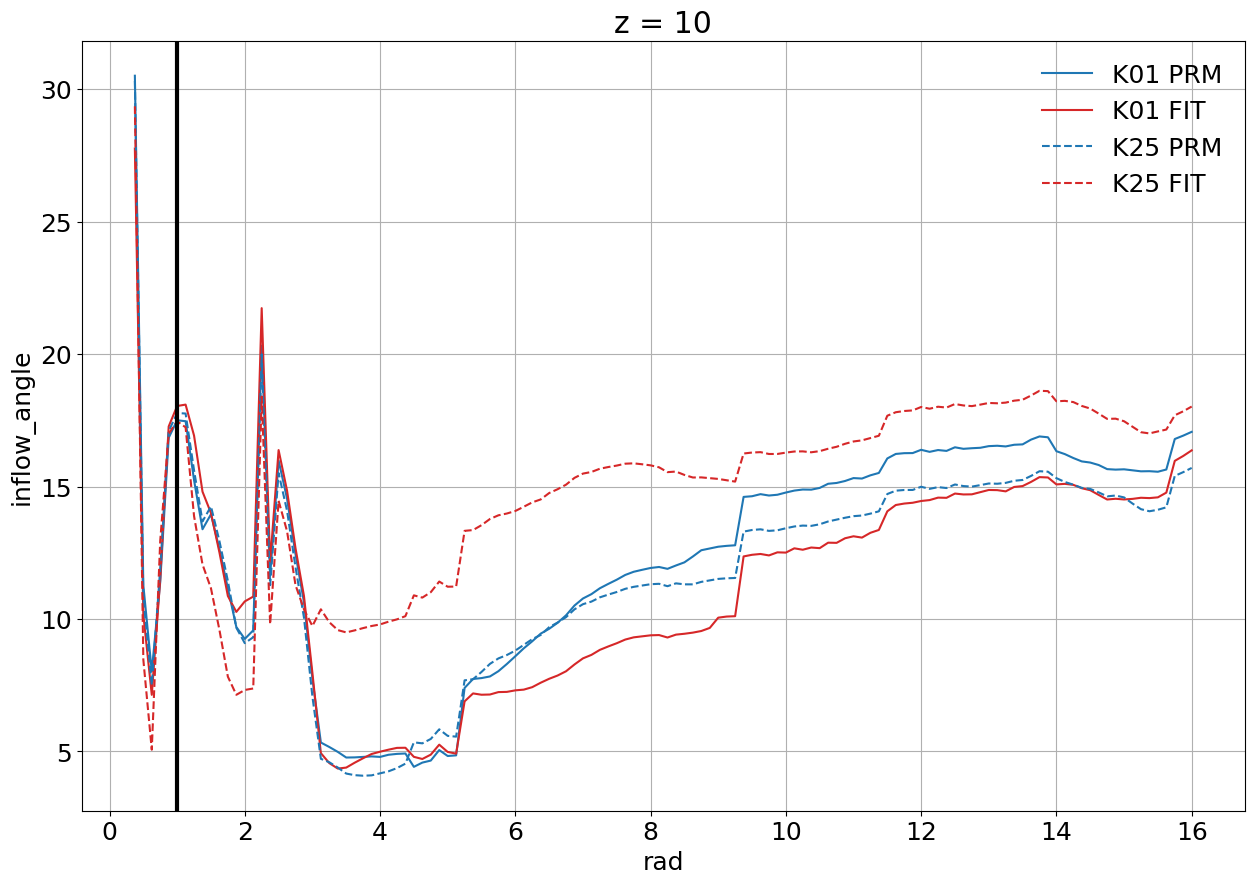

In [15]:
# Plot
abs(iadk01p_).mean(dim='idx', skipna=True).plot(label='K01 PRM', c='tab:blue')
abs(iadk01f_).mean(dim='idx', skipna=True).plot(label='K01 FIT', c='tab:red')
abs(iadk25p_).mean(dim='idx', skipna=True).plot(label='K25 PRM', c='tab:blue', linestyle='dashed')
abs(iadk25f_).mean(dim='idx', skipna=True).plot(label='K25 FIT', c='tab:red',  linestyle='dashed')
plt.grid()
plt.legend(frameon=False)
plt.axvline(1, c='k', linewidth=3)
# plt.xlim(0, 250000)